In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

# metadata
print(communities_and_crime.metadata)

# variable information
print(communities_and_crime.variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'title': 'A data-driven software tool for enabling cooperative information sharing among police departmen

In [3]:
X.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?


In [4]:
y.head()

,ViolentCrimesPerPop
0,0.20
1,0.67
2,0.43
3,0.12
4,0.03


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Step 3: Classification
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
class GaussianNaiveBayesClassifierManual:
    def __init__(self):
        self.class_priors = None
        self.class_means = None
        self.class_variances = None

    def fit(self, X_train, y_train):
        self.class_priors = {}
        self.class_means = {}
        self.class_variances = {}
        classes = np.unique(y_train)

        for c in classes:
            X_c = X_train[np.squeeze(y_train) == c]  # Ensure boolean index is correctly aligned
            self.class_priors[c] = len(X_c) / len(X_train)
            self.class_means[c] = np.mean(X_c, axis=0)
            self.class_variances[c] = np.var(X_c, axis=0)

    def predict(self, X_test):
        predictions = []

        for x_test in X_test:
            posteriors = []
            for c in self.class_priors:
                prior = np.log(self.class_priors[c])
                likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[c]) + (x_test - self.class_means[c])**2 / (2 * self.class_variances[c]))
                posterior = prior + likelihood
                posteriors.append(posterior)
            prediction = max(enumerate(posteriors), key=lambda x: x[1])[0]
            predictions.append(prediction)

        return np.array(predictions)

In [14]:
class ConfusionMatrix:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.n_classes = len(np.unique(y_true))
        self.matrix = self._compute_confusion_matrix()

    def _compute_confusion_matrix(self):
        matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
        #To Do
        for true_label, pred_label in zip(self.y_true, self.y_pred):
            matrix[true_label][pred_label] += 1

        return matrix

    def plot(self):
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.matrix, annot=True, cmap='Blues', fmt='d', xticklabels=np.arange(self.n_classes), yticklabels=np.arange(self.n_classes))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

In [15]:
class EvaluationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.confusion_matrix = ConfusionMatrix(y_true, y_pred)
        self.metrics = self._compute_metrics()

    def _compute_metrics(self):
        tp = np.diag(self.confusion_matrix.matrix)
        fp = np.sum(self.confusion_matrix.matrix, axis=0) - tp#To Do
        fn = np.sum(self.confusion_matrix.matrix, axis=1) - tp#To Do
        tn = np.sum(self.confusion_matrix.matrix) - (tp + fp + fn)#To Do

        sensitivity = tp/(tp +fn)
        specificity = tn / (tn + fp)
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)

        return {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'FPR': fpr,
            'FNR': fnr,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])

<ipython-input-19-3e956804f9b2>:26: RuntimeWarning: divide by zero encountered in log
  likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[c]) + (x_test - self.class_means[c])**2 / (2 * self.class_variances[c]))
<ipython-input-19-3e956804f9b2>:26: RuntimeWarning: divide by zero encountered in divide
  likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[c]) + (x_test - self.class_means[c])**2 / (2 * self.class_variances[c]))
<ipython-input-19-3e956804f9b2>:26: RuntimeWarning: invalid value encountered in divide
  likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[c]) + (x_test - self.class_means[c])**2 / (2 * self.class_variances[c]))
<ipython-input-19-3e956804f9b2>:26: RuntimeWarning: invalid value encountered in add
  likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.class_variances[c]) + (x_test - self.class_means[c])**2 / (2 * self.class_variances[c]))


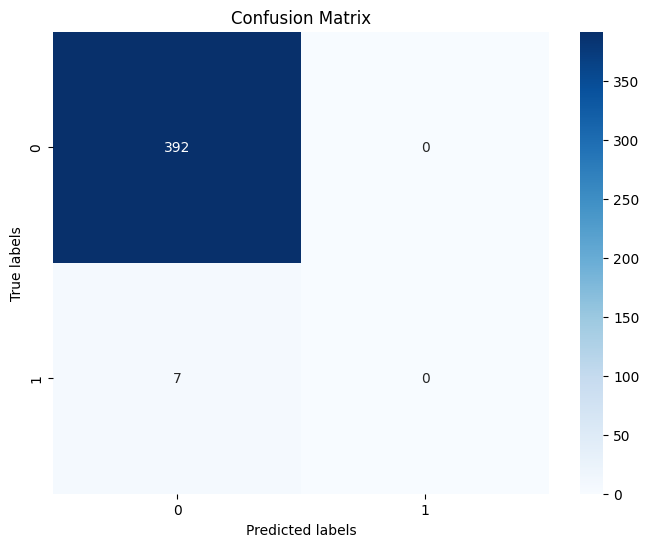

In [20]:
#Write a main to test all the above functions
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
classifier = GaussianNaiveBayesClassifierManual()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
predictions = np.ravel(predictions).astype(int)
y_test = np.ravel(y_test).astype(int)
cm = ConfusionMatrix(y_test, predictions)
cm.plot()

In [21]:
evaluation_metrics = EvaluationMetrics(y_test, predictions)
print("Evaluation Metrics:")
for metric_name, metric_value in evaluation_metrics.metrics.items():
    print(f"{metric_name}: {metric_value}")

Evaluation Metrics:
Sensitivity: [1. 0.]
Specificity: [0. 1.]
FPR: [1. 0.]
FNR: [0. 1.]
Precision: [0.98245614        nan]
Recall: [1. 0.]
F1 Score: [0.99115044        nan]


<ipython-input-15-c077baf43c01>:18: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
